In [1]:
import os
import time
import json
import random
import numpy as np
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, LSTM, Dense, Dropout,
    Conv1D, BatchNormalization, InputLayer
)
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2 as l2_reg
from tensorflow.keras.metrics import AUC

from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import compute_class_weight

from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

from niapy.problems import Problem
from niapy.task import OptimizationType, Task
from niapy.algorithms.basic import MonarchButterflyOptimization

from rdkit import Chem
from rdkit.Chem import rdmolfiles


2025-12-04 22:55:14.534800: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-04 22:55:15.150607: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-04 22:55:17.947140: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [6]:
df = pd.read_csv('/home/dito-adistya/Dito/TA/Coding/LSTM-MBA/data/GSARPC3.csv')
df['smiles'] = df['smiles']

df['target'] = df['categories'].apply(lambda x: 1 if x == "inhibitor" else 0)
print("Distribusi label:")
print(df['target'].value_counts(normalize=True))

df_train, df_test = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['target']
)


Distribusi label:
target
0    0.504717
1    0.495283
Name: proportion, dtype: float64


In [7]:
# -------------------------------------------------------
# 1. Generate randomized SMILES ala SMILESX
# -------------------------------------------------------
def augment_smiles(smiles, n_aug=3):
    """
    Produce up to n_aug randomized SMILES using RDKit's randomization.
    Returns list of unique SMILES.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return []

    augmented = set()
    for _ in range(n_aug):
        rand_smi = Chem.MolToSmiles(
            mol,
            doRandom=True,
            canonical=False,
            isomericSmiles=True
        )
        augmented.add(rand_smi)

    return list(augmented)


In [8]:
def augment_training_df(df_train, n_aug=3):
    """ #n aug == 3
    Input: original df_train (smiles, target)
    Output: df_train_final (original + augmented)
    """
    augmented_rows = []

    for _, row in df_train.iterrows():
        smi = row['smiles']
        tgt = row['target']

        aug_list = augment_smiles(smi, n_aug=n_aug)

        for aug_smi in aug_list:
            augmented_rows.append([aug_smi, tgt])

    # Convert to DF
    df_aug = pd.DataFrame(augmented_rows, columns=["smiles", "target"])

    # Remove dupes (important)
    df_aug = df_aug.drop_duplicates(subset=["smiles"])

    print(f"Generated augmented SMILES: {len(df_aug)}")

    # Combine original + augmented
    df_train_final = pd.concat([df_train, df_aug], ignore_index=True)

    # Shuffle
    df_train_final = df_train_final.sample(frac=1, random_state=42).reset_index(drop=True)

    print("Final train size:", len(df_train_final))
    return df_train_final

In [9]:
df_train_final = augment_training_df(df_train, n_aug=2)


Generated augmented SMILES: 1016
Final train size: 1524


In [10]:
df_train_final

,cid,smiles,acvalue,categories,target
0,NaN,c12C3(OCCCO3)C(=O)N(c2ccc(Br)c1)CC(=O)Nc1ccc(C...,NaN,NaN,1
1,24753719.0,COC1=CC=C(C=C1)CN2C=CC3=C2C=C(C=C3)C(=O)NO,19.2,neutral,0
2,NaN,c1cc2ccc1Oc1cc(c(NS(c3cccc([N+]([O-])=O)c3)(=O...,NaN,NaN,1
3,NaN,c12c(nc(Sc3c(-c4ccc(OC)c(OC)c4OC)nc(o3)-c3cccc...,NaN,NaN,1
4,NaN,C1(=C)C2C(O)C3(C(C(C2)O)C24CCCC(C4CC3OC2OCCn2n...,NaN,NaN,1
...,...,...,...,...,...
1519,NaN,CC(C)(C)c1cc(cc2c1oc(c(-c1cc(OC)c(OC)c(c1)OC)c...,NaN,NaN,0
1520,NaN,c1(c(OC)ccc(c1)C=C(C(c1cc(OC)c(OC)c(c1)OC)=C)C)O,NaN,NaN,1
1521,NaN,n1nc(sc1Sc1c(O)c2c(cccc2)c(c1)NC(c1ccc(Cl)cc1)...,NaN,NaN,0
1522,NaN,CCC(CC)(CCOc1c(C)cc(C(CC)(c2n(CC)c(cc2)C(=O)NC...,NaN,NaN,1


In [11]:
import re
import numpy as np

# Tokenizer pattern
pattern = re.compile(
    r"(\[[^\]]*\]|Br|Cl|Si|Se|@@?|==?|##?|/|\\|\(|\)|\.|\+|\-|%\d\d|%\d|\d|[A-Z][a-z]?|[a-z])"
)

def tokenize(smiles):
    return pattern.findall(smiles)

# ============================
# BUILD VOCABULARY FROM TRAIN
# ============================

all_tokens = []
for s in df_train_final['smiles']:
    toks = tokenize(s)
    all_tokens.extend(toks)

vocab = sorted(set(all_tokens))

token_to_int = {tok: i+2 for i, tok in enumerate(vocab)}  
token_to_int['<PAD>'] = 0
token_to_int['<UNK>'] = 1    # <--- WAJIB

vocab_size = len(token_to_int)
print("vocab_size:", vocab_size)


# ============================
# MAX SEQ LENGTH (SAFE)
# ============================

MAX_LEN = min(250, max(len(tokenize(s)) for s in df_train_final['smiles']) + 5)


# ============================
# CONVERTER SMILES → SEQUENCE
# ============================

def smiles_to_seq(smiles_list, max_len):
    seqs = []
    for s in smiles_list:
        toks = tokenize(s)
        # map unknown tokens --> <UNK> = 1
        seq = [token_to_int.get(t, 1) for t in toks]

        # right padding
        if len(seq) > max_len:
            seq = seq[:max_len]
        else:
            seq += [0] * (max_len - len(seq))  # <PAD>=0
        
        seqs.append(seq)

    return np.array(seqs, dtype=np.int32)


# ============================
# APPLY TO TRAIN & TEST
# ============================

X_train = smiles_to_seq(df_train_final['smiles'].tolist(), MAX_LEN)
X_test  = smiles_to_seq(df_test['smiles'].tolist(), MAX_LEN)

y_train = df_train_final['target'].values.astype(np.float32)
y_test  = df_test['target'].values.astype(np.float32)

print(f"X_train: {X_train.shape} | vocab: {vocab_size} | max_len: {MAX_LEN}")


vocab_size: 40
X_train: (1524, 170) | vocab: 40 | max_len: 170


In [12]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {int(cls): float(w) for cls, w in zip(classes, weights)}
print("Class weights:", class_weight_dict)


Class weights: {0: 0.9921875, 1: 1.007936507936508}


In [13]:
def build_model(
    embedding_dim=128,
    use_conv=True,
    conv_filters=64,
    conv_kernel_size=5,
    lstm_units=128,    
    dropout_rate=0.3,
    learning_rate=0.001
):
    model = Sequential()
    
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        mask_zero=True
    ))
    
    if use_conv:
        model.add(Conv1D(conv_filters, conv_kernel_size, activation='relu', padding='same'))
        model.add(BatchNormalization())
    
    
    model.add(LSTM(lstm_units, return_sequences=False))
    #model.add(LSTM(lstm_units//2, return_sequences=1))
    #model.add(LSTM((lstm_units//2)//2, return_sequences=0))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', 'AUC']
    )
    return model

In [14]:
model = build_model(
    embedding_dim=128,
    use_conv=False,
    conv_filters=64,
    conv_kernel_size=5,
    lstm_units=32,
    dropout_rate=0.2,
    learning_rate=0.005
)

callbacks = [
    EarlyStopping(monitor='val_AUC', mode='max', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6),  
    ModelCheckpoint('fixed_model.keras', monitor='val_AUC', mode='max', save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,           
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100


2025-12-04 22:57:12.802512: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 159ms/step - AUC: 0.5608 - accuracy: 0.5354 - loss: 0.6889 - val_AUC: 0.6341 - val_accuracy: 0.5703 - val_loss: 0.6783 - learning_rate: 0.0050
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - AUC: 0.6331 - accuracy: 0.5873 - loss: 0.6621 - val_AUC: 0.7142 - val_accuracy: 0.6250 - val_loss: 0.6396 - learning_rate: 0.0050
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - AUC: 0.6598 - accuracy: 0.6102 - loss: 0.6518 - val_AUC: 0.7335 - val_accuracy: 0.6875 - val_loss: 0.6109 - learning_rate: 0.0050
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - AUC: 0.6851 - accuracy: 0.6430 - loss: 0.6370 - val_AUC: 0.7325 - val_accuracy: 0.6719 - val_loss: 0.6156 - learning_rate: 0.0050
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - AUC: 0.7188 - accuracy: 0.6581 - loss: 0.6173 - val_AUC: 0.7409 - val_accuracy: 0.7031 - val_loss: 0.6008 - learning_rate: 0.0050
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - AUC: 0.7186 - accuracy: 0.6680 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step 

=evaluation
ROC-AUC       : 0.8652
Akurasi       : 0.7734

Classification Report:
              precision    recall  f1-score   support

     Neutral       0.75      0.83      0.79        65
   Inhibitor       0.80      0.71      0.76        63

    accuracy                           0.77       128
   macro avg       0.78      0.77      0.77       128
weighted avg       0.78      0.77      0.77       128



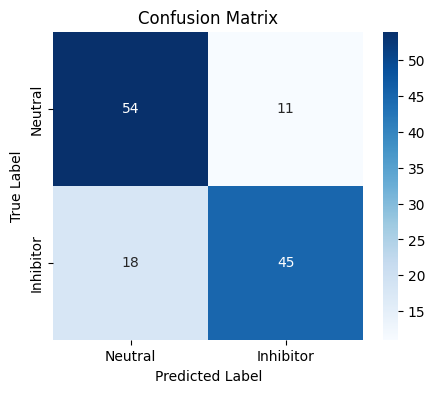

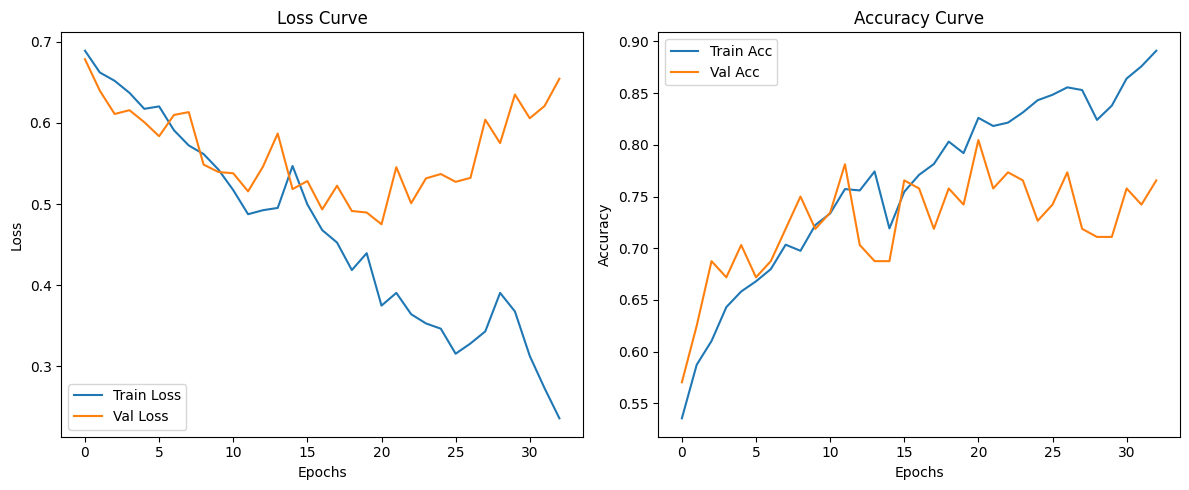

In [15]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

roc_auc = roc_auc_score(y_test, y_pred_prob)
print("\n=evaluation")
print(f"ROC-AUC       : {roc_auc:.4f}")
print(f"Akurasi       : {np.mean(y_pred == y_test):.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Neutral', 'Inhibitor']))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Neutral', 'Inhibitor'],
            yticklabels=['Neutral', 'Inhibitor'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

def plot_history(history):
    metrics = [m for m in history.history.keys() if not m.startswith('val_')]
    val_metrics = [f'val_{m}' for m in metrics if f'val_{m}' in history.history]

    plt.figure(figsize=(12,5))
    
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    if 'auc' in history.history:
        plt.subplot(1,2,2)
        plt.plot(history.history['auc'], label='Train AUC')
        plt.plot(history.history['val_auc'], label='Val AUC')
        plt.title('ROC-AUC Curve')
        plt.xlabel('Epochs')
        plt.ylabel('AUC')
        plt.legend()
    else:
        plt.subplot(1,2,2)
        plt.plot(history.history['accuracy'], label='Train Acc')
        plt.plot(history.history['val_accuracy'], label='Val Acc')
        plt.title('Accuracy Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)


In [25]:
def build_model(
    embedding_dim=128,
    use_conv=True,
    conv_filters=64,
    conv_kernel_size=5,
    lstm_units=128,    
    dropout_rate=0.3,
    learning_rate=0.001
):
    model = Sequential()
    
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        mask_zero=True
    ))
    
    if use_conv:
        model.add(Conv1D(conv_filters, conv_kernel_size, activation='relu', padding='same'))
        model.add(BatchNormalization())
    
    
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(LSTM(lstm_units//2, return_sequences=False))
    #model.add(LSTM((lstm_units//2)//2, return_sequences=0))
    #model.add(Dropout(dropout_rate))
    #model.add(Dense(16, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', 'AUC']
    )
    return model

In [39]:
model = build_model(
    embedding_dim=128,
    use_conv=False,
    conv_filters=64,
    conv_kernel_size=5,
    lstm_units=128,
    dropout_rate=0.3,
    learning_rate=0.0005
)

callbacks = [
    EarlyStopping(monitor='val_AUC', mode='max', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6),  
    ModelCheckpoint('fixed_model.keras', monitor='val_AUC', mode='max', save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,           
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - AUC: 0.5316 - accuracy: 0.5174 - loss: 0.6923 - val_AUC: 0.6498 - val_accuracy: 0.6328 - val_loss: 0.6811 - learning_rate: 5.0000e-04
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - AUC: 0.6107 - accuracy: 0.5795 - loss: 0.6841 - val_AUC: 0.6929 - val_accuracy: 0.6406 - val_loss: 0.6474 - learning_rate: 5.0000e-04
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - AUC: 0.6536 - accuracy: 0.6314 - loss: 0.6618 - val_AUC: 0.7314 - val_accuracy: 0.6562 - val_loss: 0.6264 - learning_rate: 5.0000e-04
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.6319 - accuracy: 0.5924 - loss: 0.6637 - val_AUC: 0.6976 - val_accuracy: 0.6250 - val_loss: 0.6358 - learning_rate: 5.0000e-04
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - AUC: 0.6540 - accuracy: 0.6146 - loss: 0.6617 - val_AUC: 0.7328 - val_accuracy: 0.6641 - val_loss: 0.6046 - learning_rate: 5.0000e-04
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 

=evaluation
ROC-AUC       : 0.7480
Akurasi       : 0.7031

Classification Report:
              precision    recall  f1-score   support

     Neutral       0.68      0.78      0.73        65
   Inhibitor       0.74      0.62      0.67        63

    accuracy                           0.70       128
   macro avg       0.71      0.70      0.70       128
weighted avg       0.71      0.70      0.70       128



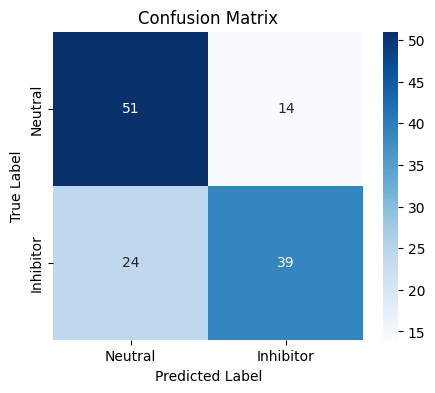

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


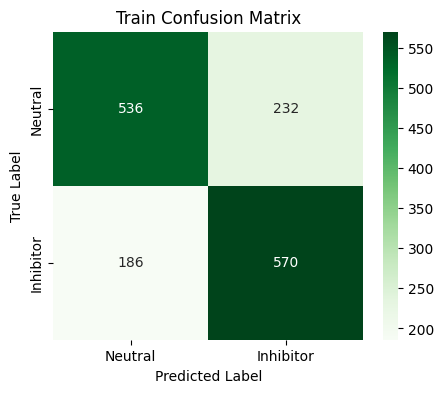

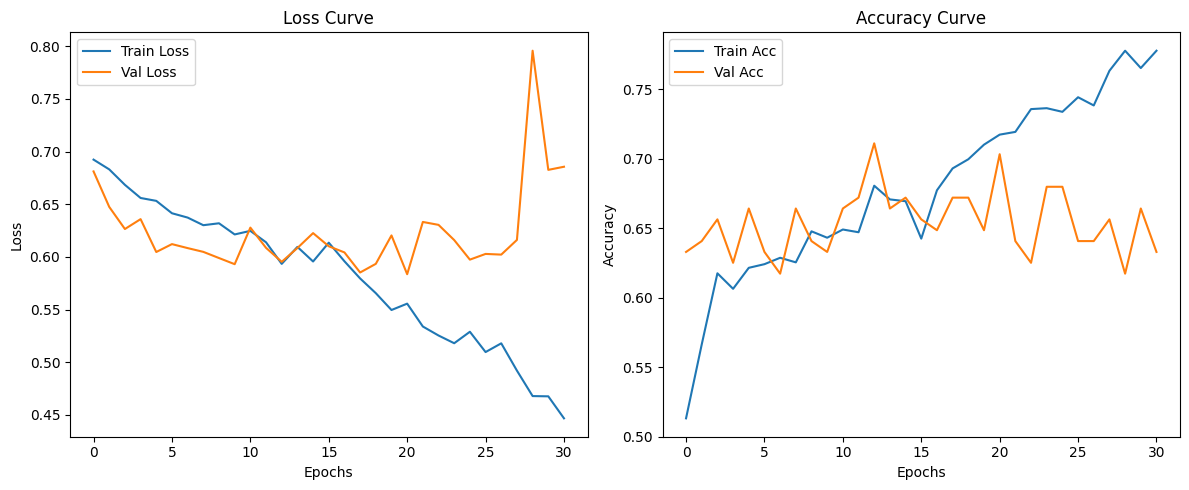

In [40]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

roc_auc = roc_auc_score(y_test, y_pred_prob)
print("\n=evaluation")
print(f"ROC-AUC       : {roc_auc:.4f}")
print(f"Akurasi       : {np.mean(y_pred == y_test):.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Neutral', 'Inhibitor']))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Neutral', 'Inhibitor'],
            yticklabels=['Neutral', 'Inhibitor'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# ====== TRAIN CONFUSION MATRIX ======
y_pred_train_prob = model.predict(X_train).flatten()
y_pred_train = (y_pred_train_prob > 0.5).astype(int)

cm_train = confusion_matrix(y_train, y_pred_train)

plt.figure(figsize=(5,4))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Neutral', 'Inhibitor'],
            yticklabels=['Neutral', 'Inhibitor'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Train Confusion Matrix')
plt.show()

def plot_history(history):
    metrics = [m for m in history.history.keys() if not m.startswith('val_')]
    val_metrics = [f'val_{m}' for m in metrics if f'val_{m}' in history.history]

    plt.figure(figsize=(12,5))
    
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    if 'auc' in history.history:
        plt.subplot(1,2,2)
        plt.plot(history.history['auc'], label='Train AUC')
        plt.plot(history.history['val_auc'], label='Val AUC')
        plt.title('ROC-AUC Curve')
        plt.xlabel('Epochs')
        plt.ylabel('AUC')
        plt.legend()
    else:
        plt.subplot(1,2,2)
        plt.plot(history.history['accuracy'], label='Train Acc')
        plt.plot(history.history['val_accuracy'], label='Val Acc')
        plt.title('Accuracy Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)


In [ ]:
print(X_train[0])


In [ ]:
import numpy as np

def count_middle_padding(X):
    bad_sequences = 0
    bad_indices = []

    for i, seq in enumerate(X):
        seq = np.array(seq)
        
        # Cari posisi token != 0 (bagian sebenarnya)
        nonzero_pos = np.where(seq != 0)[0]

        if len(nonzero_pos) == 0:
            continue
        
        first = nonzero_pos[0]
        last = nonzero_pos[-1]

        # Slice bagian tengah (yang seharusnya tidak boleh ada 0)
        middle = seq[first:last+1]
        
        # Kalau ada 0 di tengah --> padding tidak right-padded
        if 0 in middle:
            bad_sequences += 1
            bad_indices.append(i)
    
    return bad_sequences, bad_indices


# MBO

In [41]:
def decode_solution(x):
    n_layers = int(np.clip(round(x[0]), 1, 3))
    u1 = int(np.clip(round(x[1]), 16, 192))
    u2 = int(np.clip(round(x[2]), 16, 192))
    u3 = int(np.clip(round(x[3]), 16, 192))
    lr = float(10 ** np.clip(x[4], -3.3, -2.3))

    if n_layers == 1:
        units = (u1,)
    elif n_layers == 2:
        units = (u1, u2)
    else:
        units = (u1, u2, u3)

    return {
        'n_layers': n_layers,
        'units': units,
        'lr': lr
    }

In [42]:
# Fungsi untuk membangun model LSTM secara dinamis
def build_lstm_dynamic(params, vocab_size):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=64, mask_zero=True))

    n_layers = params['n_layers']
    units = params['units']

    for i in range(n_layers):
        return_sequences = (i < n_layers - 1)
        model.add(LSTM(units[i], activation='tanh', return_sequences=return_sequences))

    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [44]:
class LSTMHyperparameterOptimization(Problem):
    def __init__(self, X_train, y_train, X_val, y_val, vocab_size, max_epochs=50):
        # Dimensi solusi: n_layers, u1, u2, u3, lr
        super().__init__(dimension=5, lower=0, upper=1)
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.vocab_size = vocab_size
        self.max_epochs = max_epochs

    def _evaluate(self, x):
        # Decode solusi ke hyperparameter
        params = decode_solution(x)

        # Bangun model
        model = build_lstm_dynamic(params, self.vocab_size)

        # Kompilasi model
        optimizer = Adam(learning_rate=params['lr'])
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', AUC(name='auc')])

        # Callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=0)

        # Latih model
        try:
            history = model.fit(
                self.X_train, self.y_train,
                epochs=self.max_epochs,
                batch_size=16,
                validation_data=(self.X_val, self.y_val),
                callbacks=[early_stopping, reduce_lr],
                verbose=0
            )
            
            # Evaluasi model pada data validasi
            val_loss, val_acc, val_auc = model.evaluate(self.X_val, self.y_val, verbose=0)
            
            # Kita ingin meminimalkan validation loss, jadi return nilai val_loss
            return val_loss
            
        except Exception as e:
            # Jika terjadi error (misalnya karena arsitektur tidak stabil), return skor buruk
            print(f"Error saat mengevaluasi solusi {x}: {e}")
            # Karena kita meminimalkan, gunakan nilai besar untuk menghukum solusi yang bermasalah
            return float('inf')  # atau nilai besar lainnya, misalnya 10.0

In [ ]:
# Definisikan problem
problem = LSTMHyperparameterOptimization(X_train, y_train, X_test, y_test, vocab_size)

# Definisikan task (MINIMIZATION untuk loss)
task = Task(problem=problem, max_iters=10, optimization_type=OptimizationType.MINIMIZATION)

# Definisikan algoritma MBO
algo = MonarchButterflyOptimization(population_size=10, partition=5.0 / 12.0, period=1.2, seed=42)

# Jalankan optimasi
best_params_vector, best_loss = algo.run(task)

# Decode hasil terbaik
best_params = decode_solution(best_params_vector)

print('Best parameters found by MBO (minimizing loss):', best_params)
print('Best validation loss:', best_loss)

task.plot_convergence(x_axis='iters')

xmod1, ymod1 = task.convergence_data(x_axis='iters')

data_json = json.dumps({
    "evaluation": xmod1.tolist(),
    "fitness": ymod1.tolist()
})

In [ ]:
def build_model(vocab_size,
                embedding_dim=50,
                n_layers=1,
                units=(16,),
                dropout_rate=0.3,
                lr=0.001):
    
    model = Sequential()

    # ---- EMBEDDING ----
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        mask_zero=True
    ))

    # ---- DYNAMIC LSTM STACK ----
    for i in range(n_layers):
        return_seq = (i < n_layers - 1)  
        model.add(LSTM(units[i], return_sequences=return_seq))
        model.add(Dropout(dropout_rate))

    # ---- DENSE ----
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    # ---- COMPILE ----
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(name='AUC')]
    )

    return model


In [118]:
model = build_model(
    vocab_size=vocab_size,
    embedding_dim=128,
    n_layers=best_params['n_layers'],
    units=best_params['units'],
    dropout_rate=0.2,
    lr=best_params['lr']
)


callbacks = [
    EarlyStopping(monitor='val_AUC', mode='max', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6),  
    ModelCheckpoint('fixed_model.keras', monitor='val_AUC', mode='max', save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,           
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=0
)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  

=evaluation
ROC-AUC       : 0.7951
Akurasi       : 0.7188

Classification Report:
              precision    recall  f1-score   support

     Neutral       0.67      0.86      0.76        65
   Inhibitor       0.80      0.57      0.67        63

    accuracy                           0.72       128
   macro avg       0.74      0.72      0.71       128
weighted avg       0.74      0.72      0.71       128



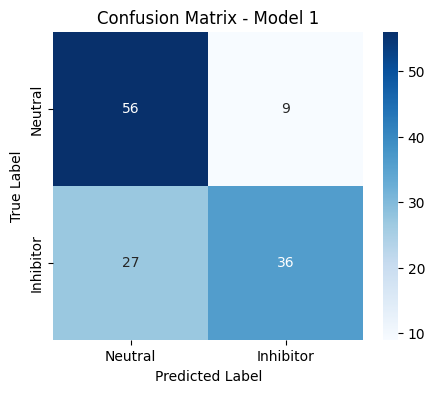

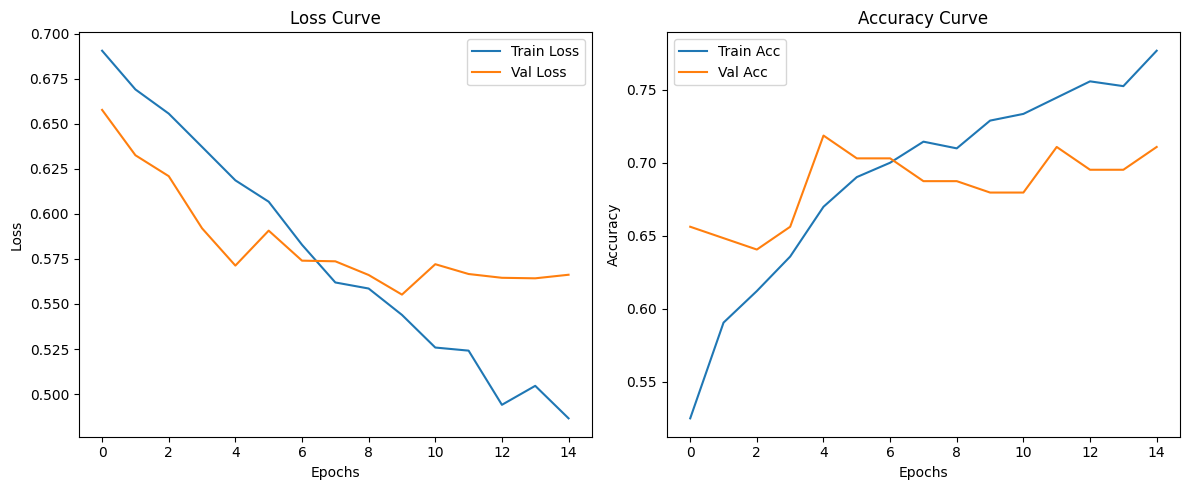

In [119]:
y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

roc_auc = roc_auc_score(y_test, y_pred_prob)
print("\n=evaluation")
print(f"ROC-AUC       : {roc_auc:.4f}")
print(f"Akurasi       : {np.mean(y_pred == y_test):.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Neutral', 'Inhibitor']))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Neutral', 'Inhibitor'],
            yticklabels=['Neutral', 'Inhibitor'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - Model 1')
plt.show()

def plot_history(history):
    metrics = [m for m in history.history.keys() if not m.startswith('val_')]
    val_metrics = [f'val_{m}' for m in metrics if f'val_{m}' in history.history]

    plt.figure(figsize=(12,5))
    
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    if 'auc' in history.history:
        plt.subplot(1,2,2)
        plt.plot(history.history['auc'], label='Train AUC')
        plt.plot(history.history['val_auc'], label='Val AUC')
        plt.title('ROC-AUC Curve')
        plt.xlabel('Epochs')
        plt.ylabel('AUC')
        plt.legend()
    else:
        plt.subplot(1,2,2)
        plt.plot(history.history['accuracy'], label='Train Acc')
        plt.plot(history.history['val_accuracy'], label='Val Acc')
        plt.title('Accuracy Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)
